Imports

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio
import cv2
import os

In [2]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

Constants and hyperparameters

In [106]:
batch_size = 4
num_channels = 1
num_classes = 4
image_size = 32#28
latent_dim = 64

Loading the MNIST dataset and preprocessing it

In [ ]:
center_crop_layer = layers.CenterCrop(image_size, image_size)

def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped

def center_image1(path):
    img = cv2.imread(path)
    frame = crop_center(img)
    frame = frame[:, :, [2, 1, 0]]
    return np.array(frame)

def center_image2(path):
    frame = cv2.imread(path)
    frame_resize = cv2.resize(frame, (image_size, image_size))

In [136]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

rootLabel = '_Frames'

class_directories = [f'{rootLabel}/0', f'{rootLabel}/1', 
                     f'{rootLabel}/2', f'{rootLabel}/3']

images = np.zeros((0, image_size, image_size, 1))
labels = np.zeros([0])

for class_index, class_dir in enumerate(class_directories):
    filenames = os.listdir(class_dir)
    
    for filename in filenames:
        img_path = os.path.join(class_dir, filename)

        frame = cv2.imread(img_path)
        frame_resize = cv2.resize(frame, (image_size, image_size))
        frame_resize2 = np.mean(frame_resize, axis=2)
        frame_resize2 = np.resize(frame_resize2, (image_size, image_size, 1))

        images = np.append(images, [frame_resize2], axis=0)

        labels = np.append(labels, [(class_index)])
        break

#datagen = ImageDataGenerator(rescale=1./255)

images = images.astype("float32") / 255.0
labels = keras.utils.to_categorical(labels, num_classes)

#dataset = datagen.flow(images, labels, batch_size=batch_size)
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
print(f"Shape of training images: {images.shape}")
print(f"Shape of training labels: {labels.shape}")

Shape of training images: (712, 32, 32, 1)
Shape of training labels: (712, 4)


In [63]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)


# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


Calculating the number of input channel for the generator and discriminator

In a regular (unconditional) GAN, we start by sampling noise (of some fixed dimension) from a normal distribution. In our case, we also need to account for the class labels. We will have to add the number of classes to the input channels of the generator (noise input) as well as the discriminator (generated image input).

In [108]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

68 5


Creating the discriminator and generator

In [109]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((image_size, image_size, discriminator_in_channels)),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(4 * 4 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((4, 4, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (4, 4), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

#discriminator.summary()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 1088)              75072     
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 1088)              0         
                                                                 
 reshape_6 (Reshape)         (None, 4, 4, 68)          0         
                                                                 
 conv2d_transpose_19 (Conv2D  (None, 8, 8, 128)        139392    
 Transpose)                                                      
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                              

In [107]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((image_size * 2, image_size * 2, discriminator_in_channels)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 64, 64, 64)        5184      
                                                                 
 leaky_re_lu_107 (LeakyReLU)  (None, 64, 64, 64)       0         
                                                                 
 conv2d_67 (Conv2D)          (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_108 (LeakyReLU)  (None, 32, 32, 128)      0         
                                                                 
 global_max_pooling2d_23 (Gl  (None, 128)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_41 (Dense)            (None, 1)                 129       
                                                     

In [108]:
# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        layers.Dense(8 * 8 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((8, 8, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 8448)              1123584   
                                                                 
 leaky_re_lu_109 (LeakyReLU)  (None, 8448)             0         
                                                                 
 reshape_18 (Reshape)        (None, 8, 8, 132)         0         
                                                                 
 conv2d_transpose_41 (Conv2D  (None, 16, 16, 128)      270464    
 Transpose)                                                      
                                                                 
 leaky_re_lu_110 (LeakyReLU)  (None, 16, 16, 128)      0         
                                                                 
 conv2d_transpose_42 (Conv2D  (None, 32, 32, 128)      262272    
 Transpose)                                              

Creating a ConditionalGAN model

In [110]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

Training the Conditional GAN

In [137]:
epochs = 100
dir  = 'GAN'

checkpoint = keras.callbacks.ModelCheckpoint(
    dir, save_weights_only=True, verbose=1,
)
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)
history = cond_gan.fit(dataset,
            epochs=epochs,
            callbacks=[checkpoint])

cond_gan.load_weights(dir)

Epoch 1/100


175/178 [============================>.] - ETA: 0s - g_loss: 1.8145 - d_loss: 0.4276
Epoch 1: saving model to GAN
178/178 [==============================] - 4s 12ms/step - g_loss: 1.8149 - d_loss: 0.4273
Epoch 2/100
177/178 [============================>.] - ETA: 0s - g_loss: 1.6499 - d_loss: 0.3814
Epoch 2: saving model to GAN
178/178 [==============================] - 2s 14ms/step - g_loss: 1.6515 - d_loss: 0.3812
Epoch 3/100
177/178 [============================>.] - ETA: 0s - g_loss: 1.8890 - d_loss: 0.3752
Epoch 3: saving model to GAN
178/178 [==============================] - 3s 16ms/step - g_loss: 1.8889 - d_loss: 0.3751
Epoch 4/100
175/178 [============================>.] - ETA: 0s - g_loss: 1.8106 - d_loss: 0.3580
Epoch 4: saving model to GAN
178/178 [==============================] - 3s 14ms/step - g_loss: 1.8106 - d_loss: 0.3581
Epoch 5/100
176/178 [============================>.] - ETA: 0s - g_loss: 1.9068 - d_loss: 0.3539
Epoch 5: saving model to GAN
178/178 [=============

Interpolating between classes with the trained generator

In [138]:
def get_fake(trained_gen, label):
    _label = keras.utils.to_categorical([label], num_classes)
    _label = tf.cast(_label, tf.float32)

    interpolation_noise = tf.random.normal(shape=(1, latent_dim))
    noise_and_labels = tf.concat([interpolation_noise, _label], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake

def interpolate_class(trained_gen, first_number, second_number, num_interpolation):
    interpolation_noise = tf.random.normal(shape=(1, latent_dim))
    interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
    interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))
    
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    print(noise_and_labels.shape)
    return fake

def ShowImage(fake_images, name = ''):
    fake_images = 255.0 * fake_images
    converted_images = fake_images.astype(np.uint8)

    if len(converted_images.shape) == 3:
        converted_images = np.expand_dims(converted_images, axis=0)

    converted_images_resized = tf.image.resize(converted_images, (128, 128)).numpy().astype(np.uint8)

    if len(converted_images_resized.shape) == 4 and converted_images_resized.shape[3] == 1:
        converted_images_resized = converted_images_resized.squeeze(axis=-1)  # Remover el canal extra si es necesario
    if (len(name) > 0):
        imageio.mimsave(name, converted_images_resized, fps=1)

1/1 [==============================] - 0s 49ms/step



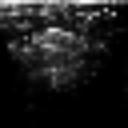

In [148]:
label = 0
name = f"{label}.jpg"
fake_images = get_fake(cond_gan.generator, label)
ShowImage(fake_images,name)
embed.embed_file(name)

In [114]:
for i in range(num_classes):
    name = f"{i}.jpg"
    fake_images = get_fake(cond_gan.generator, i)
    ShowImage(fake_images,name)
    embed.embed_file(name)

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 189ms/step
(10, 132)



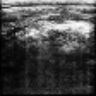

In [368]:
fake_images = interpolate_class(cond_gan.generator, 1, num_classes-1, 10)
ShowImage(fake_images)
embed.embed_file("animation.gif")